In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [116]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization,Input,Embedding,Dense,Dot, Reshape, Concatenate, LSTM, Dropout
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [117]:
tag_data=pd.read_csv("../data/genome-tags.csv")

VOCAB_SIZE=tag_data.tagId.nunique()

VOCAB_SIZE

1128

In [ ]:
train = pd.read_csv("../input/train_user_item.csv")
test = pd.read_csv("../input/test_user_item.csv")
validation = pd.read_csv("../input/validation_user_item.csv")

In [118]:
tag_data

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s
...,...,...
1123,1124,writing
1124,1125,wuxia
1125,1126,wwii
1126,1127,zombie


In [119]:
glove_embeddings=pd.read_csv("../input/Glove.csv",index_col=0)

In [120]:
import re

In [121]:
tag_data["tag"]=tag_data["tag"].apply(lambda x: re.sub("[^a-zA-Z\s]","",x))

In [122]:
tag_data

,tagId,tag
0,1,
1,2,series
2,3,th century
3,4,s
4,5,s
...,...,...
1123,1124,writing
1124,1125,wuxia
1125,1126,wwii
1126,1127,zombie


In [123]:
tokenizer=Tokenizer(num_words=VOCAB_SIZE)

In [124]:
tokenizer.fit_on_texts(tag_data["tag"])

In [125]:
word_index=tokenizer.word_index

In [126]:
word_index["imdb"]

663

In [127]:
def create_embedding_matrix(word_index_map,embeddings):
    embedding_matrix=np.zeros((len(word_index_map)+1,embeddings.shape[1]))
    c=0
    for word, index in word_index_map.items():
        embedding_vector=None
        try:
            embedding_vector = embeddings.loc[word]
        except KeyError:
            embedding_vector=None
            c+=1
        if embedding_vector is not None:
            embedding_matrix[index, :] = embedding_vector
    print(f"Could not embed {c} words")
    return embedding_matrix

In [128]:
word_index["frombook"]

241

In [129]:
len(word_index)

1155

In [130]:
glove_embeddings.loc["user"]

0    -0.53900
1     0.03310
2     0.52300
3     0.02669
4     0.61960
       ...   
95    0.02710
96   -0.01747
97   -0.87800
98    0.53800
99   -0.29610
Name: user, Length: 100, dtype: float64

In [131]:
word_index

{'best': 1,
 'oscar': 2,
 'good': 3,
 'war': 4,
 'movie': 5,
 'bad': 6,
 'nudity': 7,
 'based': 8,
 'on': 9,
 'comedy': 10,
 'the': 11,
 'plot': 12,
 'great': 13,
 's': 14,
 'ending': 15,
 'music': 16,
 'funny': 17,
 'world': 18,
 'a': 19,
 'book': 20,
 'story': 21,
 'dialogue': 22,
 'action': 23,
 'comic': 24,
 'of': 25,
 'film': 26,
 'dark': 27,
 'fantasy': 28,
 'family': 29,
 'effects': 30,
 'relationship': 31,
 'new': 32,
 'alternate': 33,
 'history': 34,
 'cinematography': 35,
 'soundtrack': 36,
 'acting': 37,
 'science': 38,
 'sequel': 39,
 'video': 40,
 'game': 41,
 'and': 42,
 'drama': 43,
 'cult': 44,
 'as': 45,
 'scifi': 46,
 'life': 47,
 'love': 48,
 'notable': 49,
 'original': 50,
 'space': 51,
 'time': 52,
 'adaptation': 53,
 'adapted': 54,
 'afi': 55,
 'reality': 56,
 'civil': 57,
 'animated': 58,
 'animation': 59,
 'cgi': 60,
 'script': 61,
 'true': 62,
 'tv': 63,
 'better': 64,
 'school': 65,
 'brothers': 66,
 'business': 67,
 'abuse': 68,
 'classic': 69,
 'america': 70

In [132]:
embedding_matrix=create_embedding_matrix(word_index,glove_embeddings)

Could not embed 25 words


In [133]:
tokenizer

In [226]:

def create_sequences(data, label="rating"):
    data.dropna(inplace=True)
    user_tags = tokenizer.texts_to_sequences(data["user_tags"].tolist())
    movie_tags = tokenizer.texts_to_sequences(data["movie_tags"].tolist())
    labels = data[label]
    
    user_tags = pad_sequences(user_tags,maxlen=8)
    movie_tags = pad_sequences(movie_tags, maxlen=16)
    return user_tags, movie_tags, labels

In [228]:
user_input, movie_input, labels = create_sequences(train.sample(5))

In [229]:
train_user, train_movie, train_y=create_sequences(train)
test_user, test_movie, test_y=create_sequences(test)

validation_user, validation_movie, validation_y=create_sequences(validation)

In [203]:
user_input

array([[   0,    0,    0,    0,  806,  114,  138,   59],
       [   0,    0,    0,    6, 1093,  221,  464,  363],
       [   0,    0,    0,    0,    0,  916,   27,   10],
       [   0,  218, 1026,  372,  764,   13,   15,   50],
       [   0,    0,    0,    0,    0,    0,    9,   16]])

In [204]:
movie_input

array([[ 137,    5,  188,  814,  137,  952,  950,  359,  890,  372,  137,
         950,  951,  359, 1047,   23],
       [   8,    9,   19,   62,   21,   37,  498,  155,  120, 1058,    5,
         637,  210, 1043,  978,    4],
       [ 705,   43,   35,  232,  145,  103,  200,    8,    9,   19,   20,
           4,  873,  431,   14,    4],
       [ 121,  123,    8,    9,  172,  865,  866,  383,  384,  123,    8,
           9,   82,   82,   10,  692],
       [ 815,  272,  553,    7,   61,  599,   14,  651,   69,  980,    2,
           1,  846,  775,   11,  431]])

In [140]:
from tensorflow.keras import Sequential, Model, layers

In [141]:
VOCAB_SIZE = len(tokenizer.word_index) + 1
EMBEDDING_DIM = 100

In [232]:
def create_model(embedding_size=16):
    user_tag=Input(name="user_tags",shape=[8])
    movie_tag=Input(name="movie_tags",shape=[16])
    
    glove_embeddings = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, weights=[embedding_matrix], input_length=8, trainable=False)
    user_tag_vectors = glove_embeddings(user_tag)
    movie_tag_vectors = glove_embeddings(movie_tag)
    
    
    user_tag_vectors = tf.unstack(user_tag_vectors, axis=-2)
    movie_tag_vectors = tf.unstack(movie_tag_vectors, axis=-2)
    
    # movie_tag_vectors = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, weights=[embedding_matrix], input_length=8, trainable=False)(user_tag)
    # movie_tag_vectors = tf.unstack(movie_tag_vectors, axis=-2)
    # user_tag_vectors = tf.expand_dims(user_tag_vectors, axis=0)
    average_layer =  layers.Average()
    
    user_embedding = average_layer(user_tag_vectors)
    movie_embedding = average_layer(movie_tag_vectors)
    
    # movie_embedding= Embedding(name = 'movie_embedding',input_dim = NUMBER_OF_MOVIES, output_dim = embedding_size)(movie_tag_vectorized)
    
    merged = Concatenate(name = 'merge_user_and_movie')([user_embedding, movie_embedding])
    
    # merged = Reshape(target_shape = [2500])(merged)
    
    merged=Dense(400, activation="elu")(merged)
    
    merged=Dense(500, activation="elu")(merged)
    
    merged=Dense(500, activation="elu")(merged)
    
    out = Dense(6, activation="softmax")(merged)
    
    # model = Model(inputs = [user_tag, movie_tag], outputs = user_embeddings)
    model = Model(inputs = [user_tag, movie_tag], outputs = out)
    
    optimizer = tf.keras.optimizers.Adam()
    
    model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model

In [220]:
np.array(padded_inputs[:1]).shape

(1, 8)

In [233]:
model = create_model()

# model.add(layers.Average())

In [234]:
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_tags (InputLayer)         [(None, 8)]          0           []                               
                                                                                                  
 movie_tags (InputLayer)        [(None, 16)]         0           []                               
                                                                                                  
 embedding_28 (Embedding)       multiple             115600      ['user_tags[0][0]',              
                                                                  'movie_tags[0][0]']             
                                                                                                  
 tf.unstack_21 (TFOpLambda)     [(None, 100),        0           ['embedding_28[0][0]']    

In [217]:
prediction = model.predict([user_input, movie_input])

In [218]:
prediction

array([[0.21174042, 0.14346305, 0.17945614, 0.14592321, 0.18248945,
        0.1369277 ],
       [0.14946398, 0.1581233 , 0.1828206 , 0.16082166, 0.18121918,
        0.16755131],
       [0.15790251, 0.1260203 , 0.18962309, 0.14929432, 0.2245023 ,
        0.1526575 ],
       [0.2124754 , 0.13887033, 0.17374124, 0.12763081, 0.20441765,
        0.14286461],
       [0.17133947, 0.1363028 , 0.15389208, 0.151352  , 0.2260354 ,
        0.1610783 ]], dtype=float32)

In [235]:
history=model.fit(
    x=[train_user,train_movie],
    y=train_y,
    batch_size=512,
    validation_data=([validation_user,validation_movie],validation_y),
    # class_weights=class_weights
    epochs=20)

Epoch 1/20
4197/4197 [==============================] - 25s 6ms/step - loss: 1.3484 - accuracy: 0.4127 - val_loss: 1.3244 - val_accuracy: 0.4251
Epoch 2/20
4197/4197 [==============================] - 24s 6ms/step - loss: 1.3120 - accuracy: 0.4306 - val_loss: 1.2970 - val_accuracy: 0.4367
Epoch 3/20
4197/4197 [==============================] - 24s 6ms/step - loss: 1.2858 - accuracy: 0.4424 - val_loss: 1.2801 - val_accuracy: 0.4454
Epoch 4/20
4197/4197 [==============================] - 24s 6ms/step - loss: 1.2638 - accuracy: 0.4520 - val_loss: 1.2504 - val_accuracy: 0.4570
Epoch 5/20
4197/4197 [==============================] - 26s 6ms/step - loss: 1.2464 - accuracy: 0.4598 - val_loss: 1.2378 - val_accuracy: 0.4643
Epoch 6/20
4197/4197 [==============================] - 28s 7ms/step - loss: 1.2328 - accuracy: 0.4654 - val_loss: 1.2315 - val_accuracy: 0.4639
Epoch 7/20
4197/4197 [==============================] - 28s 7ms/step - loss: 1.2214 - accuracy: 0.4699 - val_loss: 1.2139 - val_ac

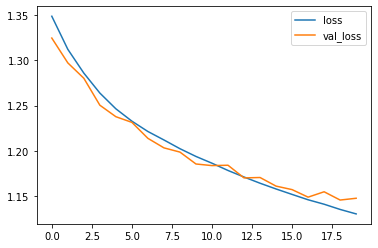

In [236]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss","val_loss"])

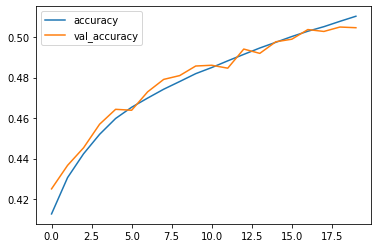

In [237]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["accuracy","val_accuracy"])

In [241]:
model.evaluate(
    x=[test_user,test_movie],
    y=test_y,
    batch_size=1024,
    )

1615/1615 [==============================] - 5s 3ms/step - loss: 1.1476 - accuracy: 0.5044


[1.1476325988769531, 0.5043641328811646]

In [245]:
predictions = model.predict([test_user,test_movie])

In [246]:
y_pred = np.argmax(predictions, axis=1)

In [247]:
y_pred

array([2, 0, 2, ..., 2, 3, 2], dtype=int64)

In [261]:
from sklearn.metrics import classification_report, recall_score, ndcg_score, mean_squared_error

In [260]:
print(classification_report(test_y, y_pred))

c:\Users\Ashwin\miniconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ashwin\miniconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.52      0.27      0.35    102701
           1       0.45      0.17      0.25    215299
           2       0.50      0.53      0.52    576074
           3       0.51      0.70      0.59    593951
           4       0.49      0.29      0.36    164880
           5       0.00      0.00      0.00         0

    accuracy                           0.50   1652905
   macro avg       0.41      0.33      0.35   1652905
weighted avg       0.50      0.50      0.48   1652905



c:\Users\Ashwin\miniconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [264]:
ndcg = np.sqrt(mean_squared_error(test_y, y_pred))

print("MSE: {:.3f}".format(ndcg))

nDCG@100: 0.950
